# 1. Hurst & Entropy

In [1]:
import pandas as pd

# Đọc file CSV
df = pd.read_csv("../data/vn30/volume.csv")

In [24]:
import numpy as np
from scipy.stats import entropy
from hurst import compute_Hc
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        # Lấy dữ liệu cho cổ phiếu hiện tại và loại bỏ giá trị NaN
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính chỉ số Hurst
            H, c, data_hurst = compute_Hc(data_no_zeros, kind='price', simplified=True)
            
            # Tính Approximate Entropy (ApEn)
            ApEn = ant.app_entropy(data_no_zeros, order=2)
            
            # Tính Sample Entropy (SampEn)
            SampEn = ant.sample_entropy(data_no_zeros, order=2)
            
            # Tính Permutation Entropy
            PermEn = ant.perm_entropy(data_no_zeros, order=3, normalize=True)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Hurst Exponent": H,
                "Approximate Entropy": ApEn,
                "Sample Entropy": SampEn,
                "Permutation Entropy": PermEn
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Chuyển đổi kết quả thành DataFrame để phân tích dễ dàng hơn
results_df = pd.DataFrame(results)

# Sắp xếp theo tên cổ phiếu để dễ đọc
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính toán thống kê để đưa ra insights
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả cho từng cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân nhóm cổ phiếu theo đặc tính Hurst
hurst_groups = {
    "Random Walk (0.45 < H < 0.55)": results_df[(results_df["Hurst Exponent"] > 0.45) & (results_df["Hurst Exponent"] < 0.55)]["Stock"].tolist(),
    "Anti-persistent (H ≤ 0.45)": results_df[results_df["Hurst Exponent"] <= 0.45]["Stock"].tolist(),
    "Persistent (H ≥ 0.55)": results_df[results_df["Hurst Exponent"] >= 0.55]["Stock"].tolist()
}

print("\nPhân tích dựa trên chỉ số Hurst:")
for category, stocks in hurst_groups.items():
    print(f"{category}: {', '.join(stocks) if stocks else 'Không có'}")

# Xác định cổ phiếu có giá trị entropy cao nhất/thấp nhất
print("\nCổ phiếu có giá trị entropy đặc biệt:")
metrics = ["Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
for metric in metrics:
    highest = results_df.loc[results_df[metric].idxmax()]
    lowest = results_df.loc[results_df[metric].idxmin()]
    print(f"Cao nhất {metric}: {highest['Stock']} ({highest[metric]:.4f})")
    print(f"Thấp nhất {metric}: {lowest['Stock']} ({lowest[metric]:.4f})")

# Phân tích tổng quan thị trường
avg_hurst = stats_df.loc["Mean", "Hurst Exponent"]
print("\nPhân tích tổng quan thị trường:")
if avg_hurst > 0.55:
    print(f"- Thị trường thể hiện xu hướng bền vững (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có xu hướng")
elif avg_hurst < 0.45:
    print(f"- Thị trường thể hiện xu hướng đảo chiều về giá trị trung bình (Hurst trung bình = {avg_hurst:.4f}), gợi ý các mẫu có tính quay về giá trị trung bình")
else:
    print(f"- Thị trường thể hiện đặc tính đi ngẫu nhiên (Hurst trung bình = {avg_hurst:.4f}), gợi ý định giá hiệu quả")

# Tương quan giữa các chỉ số
correlation = results_df.iloc[:, 1:].corr()
print("\nTương quan giữa các chỉ số:")
print(correlation.to_string(float_format=lambda x: f"{x:.4f}"))

# Phân tích thêm dựa trên các chỉ số entropy
avg_apen = stats_df.loc["Mean", "Approximate Entropy"]
avg_sampen = stats_df.loc["Mean", "Sample Entropy"]
avg_permen = stats_df.loc["Mean", "Permutation Entropy"]

print("\nPhân tích thêm:")
print(f"- Approximate Entropy trung bình: {avg_apen:.4f}")
print(f"- Sample Entropy trung bình: {avg_sampen:.4f}")
print(f"- Permutation Entropy trung bình: {avg_permen:.4f}")
print("- Giá trị entropy cao hơn chỉ ra tính ngẫu nhiên nhiều hơn và khả năng dự đoán thấp hơn")
print("- Giá trị entropy thấp hơn chỉ ra cấu trúc nhiều hơn và khả năng dự đoán cao hơn")

# Xác định các mẫu đáng chú ý hoặc ngoại lệ
outliers = []
for metric in ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]:
    mean = stats_df.loc["Mean", metric]
    std = stats_df.loc["Std", metric]
    high_outliers = results_df[results_df[metric] > mean + 2*std]["Stock"].tolist()
    low_outliers = results_df[results_df[metric] < mean - 2*std]["Stock"].tolist()
    
    if high_outliers:
        outliers.append(f"Cao bất thường trong {metric}: {', '.join(high_outliers)}")
    if low_outliers:
        outliers.append(f"Thấp bất thường trong {metric}: {', '.join(low_outliers)}")

if outliers:
    print("\nCác ngoại lệ đáng chú ý (vượt quá 2 độ lệch chuẩn):")
    for outlier in outliers:
        print(f"- {outlier}")

Kết quả cho từng cổ phiếu:
Stock  Hurst Exponent  Approximate Entropy  Sample Entropy  Permutation Entropy
  ACB          0.5779               1.3355          1.1502               0.9984
  BCM          2.3999               0.7482          0.3000               0.9989
  BID          0.7103               1.3289          1.2001               0.9954
  BVH          0.6650               1.3424          1.0356               0.9975
  CTG          0.5807               1.2670          1.0790               0.9950
  FPT          0.6371               1.2496          1.1057               0.9972
  GAS          0.6672               1.3104          1.1309               0.9967
  GVR          0.6400               1.3499          1.1798               0.9985
  HDB          0.6894               1.1710          0.8753               0.9935
  HPG          0.5869               1.5161          1.5732               0.9978
  LPB          1.0846               1.3077          1.0060               0.9947
  MBB        

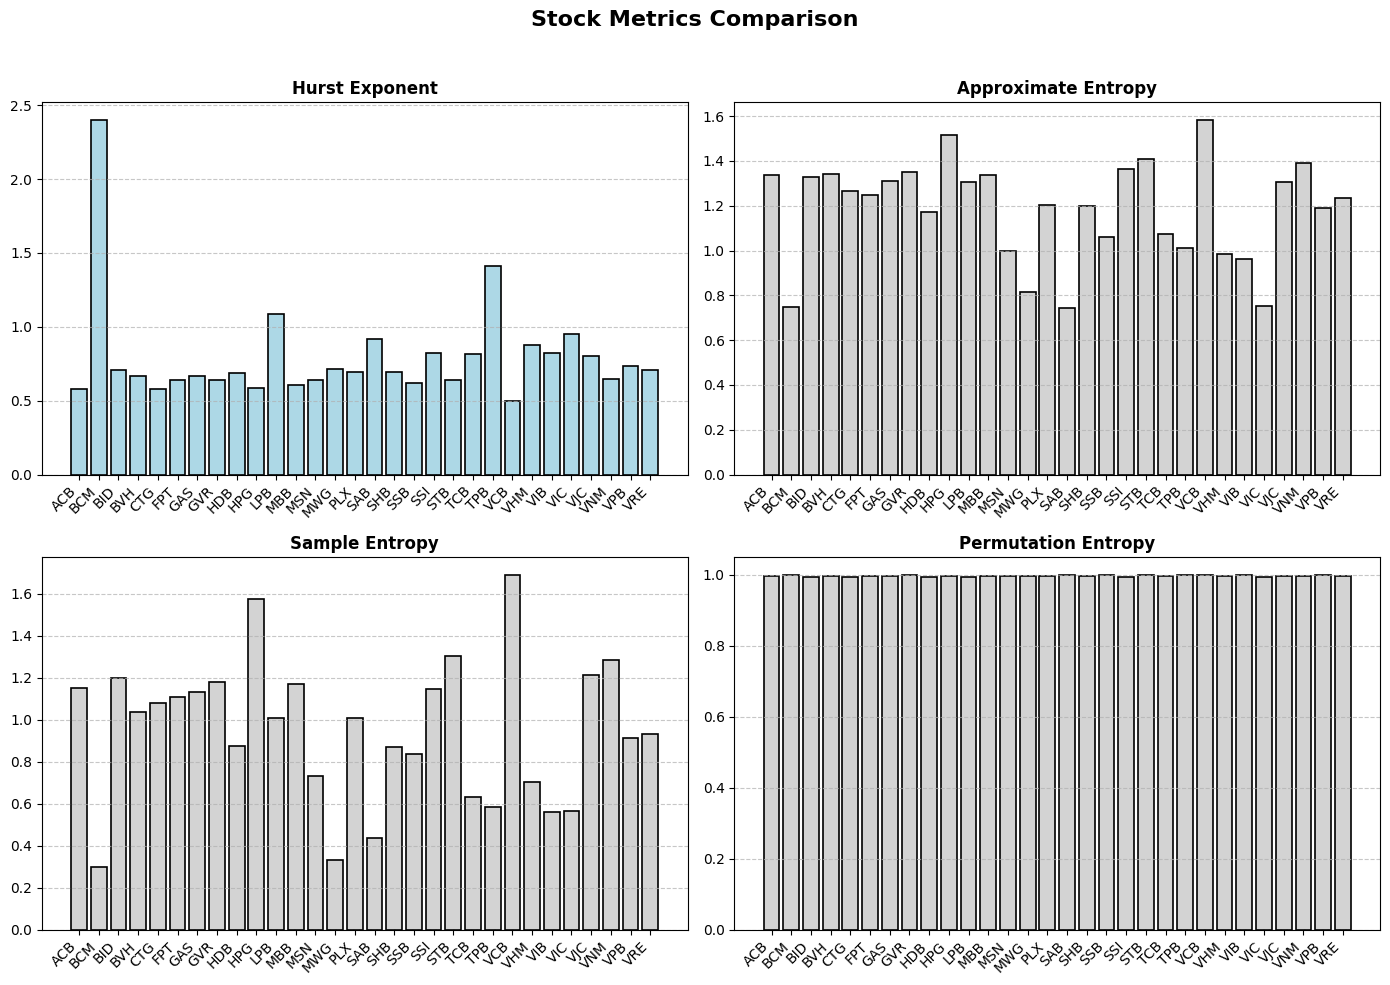

In [25]:
# Tạo lại DataFrame từ dữ liệu cung cấp
import pandas as pd
import matplotlib.pyplot as plt

df_metrics = pd.DataFrame(results_df)

# Vẽ 4 biểu đồ subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Hurst Exponent", "Approximate Entropy", "Sample Entropy", "Permutation Entropy"]
colors = ["lightblue", "lightgray", "lightgray", "lightgray"]  # Hurst màu xanh nhạt, còn lại xám

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes.flatten(), metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Tiêu đề chính cho toàn bộ subplot
fig.suptitle("Stock Metrics Comparison", fontsize=16, fontweight="bold")

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()


In [34]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import antropy as ant

# Lấy tất cả các cột chứng khoán (loại trừ cột 'time')
stock_columns = [col for col in df.columns if col != 'time']

# Khởi tạo danh sách lưu kết quả
results = []

# Hàm tính Recurrence Rate (RR)
def compute_rr(data, threshold=0.1):
    """Tính tỷ lệ tái phát"""
    data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    n = len(data_norm)
    count = 0
    for i in range(n):
        for j in range(i, n):  # Chỉ tính nửa trên của ma trận để tăng tốc
            if abs(data_norm[i] - data_norm[j]) < threshold:
                count += 1
    count = 2 * count - n  # Nhân đôi kết quả trừ đi đường chéo
    return count / (n * n)

# Hàm tính Determinism (DET)
def compute_det(data, threshold=0.1):
    """Tính độ quyết định"""
    n = len(data)
    if n <= 1:
        return 0
    autocorr = np.correlate(data, data, mode='full')[n-1:] / (n * np.var(data))
    det_points = np.sum(autocorr > threshold)
    return det_points / len(autocorr)

# Hàm tính Laminarity (LAM)
def compute_lam(data, threshold=0.1):
    """Tính độ trầm"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    lam_points = np.sum(changes < threshold)
    return lam_points / (n - 1)

# Hàm tính Trapping Time (TT)
def compute_tt(data, threshold=0.1):
    """Tính thời gian bẫy"""
    n = len(data)
    if n <= 1:
        return 0
    changes = np.abs(np.diff(data)) / np.std(data)
    is_trapped = changes < threshold
    
    trapped_segments = []
    current_segment = 0
    for trapped in is_trapped:
        if trapped:
            current_segment += 1
        else:
            if current_segment > 0:
                trapped_segments.append(current_segment)
                current_segment = 0
    if current_segment > 0:
        trapped_segments.append(current_segment)
    
    return np.mean(trapped_segments) if trapped_segments else 0

# Hàm tính Shannon Entropy
def compute_shannon(data, bins=20):
    """Tính Shannon Entropy"""
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Hàm tính KS Entropy
def compute_ks_entropy(data):
    """Tính Kolmogorov-Sinai Entropy"""
    try:
        e1 = ant.sample_entropy(data, order=2)
        e2 = ant.sample_entropy(data, order=3)
        return max(0, e2 - e1)
    except:
        return np.nan

# Xử lý từng cột chứng khoán
for stock in stock_columns:
    try:
        data = df[stock].dropna().values
        
        if len(data) > 0:
            # Thay thế giá trị 0 bằng một giá trị nhỏ để tránh lỗi log(0)
            data_no_zeros = np.where(data == 0, 1e-10, data)
            
            # Tính các chỉ số
            rr = compute_rr(data_no_zeros)
            det = compute_det(data_no_zeros)
            lam = compute_lam(data_no_zeros)
            tt = compute_tt(data_no_zeros)
            shannon_ent = compute_shannon(data_no_zeros)
            ks_ent = compute_ks_entropy(data_no_zeros)
            
            # Lưu kết quả
            results.append({
                "Stock": stock,
                "Recurrence Rate (RR)": rr,
                "Determinism (DET)": det,
                "Laminarity (LAM)": lam,
                "Trapping Time (TT)": tt,
                "Shannon Entropy": shannon_ent,
                "KS Entropy": ks_ent
            })
        else:
            print(f"Không có dữ liệu hợp lệ cho {stock}")
    except Exception as e:
        print(f"Lỗi khi xử lý {stock}: {e}")

# Tạo DataFrame kết quả và sắp xếp
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Stock").reset_index(drop=True)

# Tính các thống kê cơ bản
stats_df = pd.DataFrame({
    "Mean": results_df.mean(numeric_only=True),
    "Median": results_df.median(numeric_only=True),
    "Min": results_df.min(numeric_only=True),
    "Max": results_df.max(numeric_only=True),
    "Std": results_df.std(numeric_only=True)
}).T

# Hiển thị bảng kết quả
print("Kết quả các chỉ số theo cổ phiếu:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nThống kê tổng quan:")
print(stats_df.to_string(float_format=lambda x: f"{x:.4f}"))

Kết quả các chỉ số theo cổ phiếu:
Stock  Recurrence Rate (RR)  Determinism (DET)  Laminarity (LAM)  Trapping Time (TT)  Shannon Entropy  KS Entropy
  ACB                0.5016             0.9277            0.1793              1.3938           2.1692      0.0000
  BCM                0.5565             0.6597            0.4404              3.0559           1.8083      0.0000
  BID                0.6598             0.9352            0.1657              1.4577           1.8414      0.0000
  BVH                0.4813             0.8736            0.1721              1.3961           2.1960      0.0000
  CTG                0.4488             0.9432            0.1777              1.3962           2.2961      0.0000
  FPT                0.5723             0.9584            0.1825              1.4340           2.0253      0.0000
  GAS                0.5254             0.9192            0.1801              1.3720           2.1241      0.0000
  GVR                0.4852             0.8810        

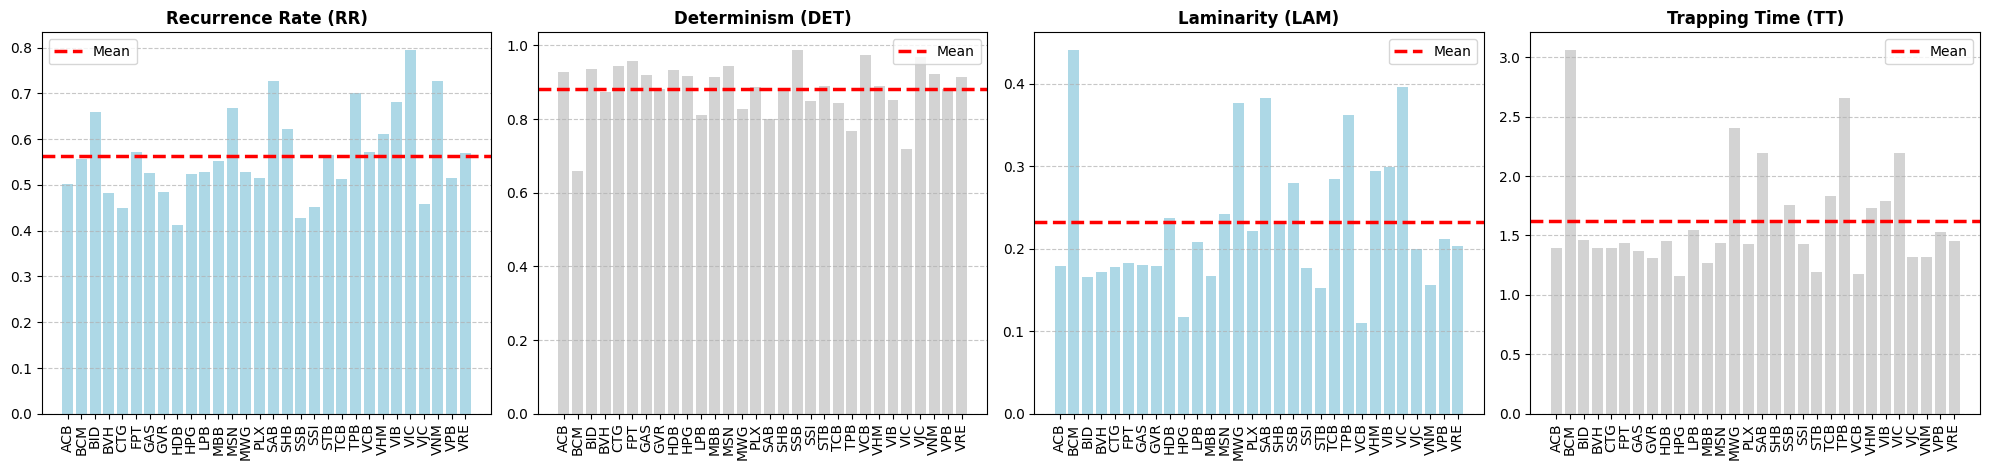

In [40]:
# Tạo lại DataFrame từ dữ liệu cung cấp
df_metrics = results_df[["Stock", "Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]]

# Tính giá trị trung bình cho từng chỉ số
mean_values = df_metrics.mean(numeric_only=True)

# Vẽ 4 biểu đồ subplot trên cùng một hàng
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

metrics = ["Recurrence Rate (RR)", "Determinism (DET)", "Laminarity (LAM)", "Trapping Time (TT)"]
colors = ["lightblue", "lightgray", "lightblue", "lightgray"]  # Áp dụng màu sắc yêu cầu

# Vẽ từng biểu đồ
for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(df_metrics["Stock"], df_metrics[metric], color=color, edgecolor='black', linewidth=0)
    ax.axhline(mean_values[metric], color='red', linestyle="--", linewidth=2.5, label="Mean")  # Đường trung bình
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(df_metrics["Stock"])))
    ax.set_xticklabels(df_metrics["Stock"], rotation=90, ha="center")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

# Tăng khoảng cách giữa các subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Hiển thị biểu đồ
plt.show()

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

# Đọc dữ liệu từ file CSV
high_df = pd.read_csv('../data/2024/high.csv')
low_df = pd.read_csv('../data/2024/low.csv')

# Lấy danh sách các công ty (tất cả các cột trừ cột 'time')
companies = [col for col in high_df.columns if col != 'time']

# Khởi tạo dictionary để lưu kết quả
results = {'company': companies}
weekly_irvs = []
monthly_irvs = []
rcis = []
srs = []
krs = []

# Xử lý từng công ty
for company in companies:
    # Tính Chỉ số Dao Động Nội Ngày (IR): giá cao - giá thấp
    IR = high_df[company] - low_df[company]
    
    # Tính Chỉ số Dao Động Nội Ngày Chuẩn Hóa (NIR): IR / (giá cao + giá thấp)
    NIR = IR / (high_df[company] + low_df[company])
    
    # Chuyển đổi thời gian sang định dạng datetime để nhóm
    time_datetime = pd.to_datetime(high_df['time'])
    
    # Tạo DataFrame với thời gian và IR để tính toán
    ir_df = pd.DataFrame({'time': time_datetime, 'IR': IR})
    
    # Thêm cột tuần và tháng
    ir_df['week'] = ir_df['time'].dt.isocalendar().week
    ir_df['year'] = ir_df['time'].dt.year
    ir_df['month'] = ir_df['time'].dt.month
    
    # Tính IRV theo tuần (độ lệch chuẩn của IR theo tuần)
    weekly_groups = ir_df.groupby(['year', 'week'])
    weekly_irv = weekly_groups['IR'].std().mean()
    weekly_irvs.append(weekly_irv)
    
    # Tính IRV theo tháng (độ lệch chuẩn của IR theo tháng)
    monthly_groups = ir_df.groupby(['year', 'month'])
    monthly_irv = monthly_groups['IR'].std().mean()
    monthly_irvs.append(monthly_irv)
    
    # Tính Chỉ số Ổn Định Dao Động (RCI): trung vị IR / trung bình IR
    mean_ir = IR.mean()
    median_ir = IR.median()
    RCI = median_ir / mean_ir if mean_ir != 0 else np.nan
    rcis.append(RCI)
    
    # Tính Chỉ số Độ Méo (SR): độ méo của phân bố IR
    SR = stats.skew(IR.dropna())
    srs.append(SR)
    
    # Tính Chỉ số Nhọn (KR): độ nhọn của phân bố IR
    KR = stats.kurtosis(IR.dropna())
    krs.append(KR)

# Thêm tất cả các chỉ số vào kết quả
results['Weekly_IRV'] = weekly_irvs
results['Monthly_IRV'] = monthly_irvs
results['RCI'] = rcis
results['SR'] = srs
results['KR'] = krs

# Tạo DataFrame từ kết quả
results_df = pd.DataFrame(results)

# Lưu vào file CSV
results_df.to_csv('stock_metrics.csv', index=False)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

# Đọc file kết quả đã tạo
results_df = pd.read_csv('stock_metrics.csv')

# 1. HEATMAP - Bản đồ nhiệt
def create_heatmap(df):
    # Chuẩn hóa dữ liệu để so sánh được các chỉ số khác nhau
    df_norm = df.copy()
    for col in df.columns:
        if col != 'company':
            df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    # Đặt company làm chỉ mục
    df_pivot = df_norm.set_index('company')
    
    # Tạo bản đồ nhiệt
    plt.figure(figsize=(12, 10))
    custom_cmap = LinearSegmentedColormap.from_list('custom_viridis', 
                                                   [(0, '#440154'), (0.5, '#21908C'), (1, '#FDE725')])
    
    sns.heatmap(df_pivot, annot=True, fmt='.2f', cmap=custom_cmap, 
                linewidths=.5, cbar_kws={'label': 'Giá trị chuẩn hóa'})
    
    plt.title('Bản đồ nhiệt các chỉ số dao động theo công ty', fontsize=16)
    plt.tight_layout()
    plt.savefig('heatmap_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()

# 2. RADAR CHART - Biểu đồ radar
def create_radar_chart(df, selected_companies=None):
    if selected_companies is None:
        # Chọn 5 công ty đầu tiên làm mẫu nếu không có chỉ định
        selected_companies = df['company'].iloc[:5].tolist()
    
    # Lọc dữ liệu cho các công ty đã chọn
    df_selected = df[df['company'].isin(selected_companies)]
    
    # Chuẩn hóa dữ liệu
    df_norm = df_selected.copy()
    for col in df.columns:
        if col != 'company':
            max_val = df[col].max()
            min_val = df[col].min()
            if max_val != min_val:
                df_norm[col] = (df_selected[col] - min_val) / (max_val - min_val)
    
    # Tạo biểu đồ radar với Plotly
    categories = [col for col in df.columns if col != 'company']
    
    fig = go.Figure()
    
    for i, company in enumerate(selected_companies):
        company_data = df_norm[df_norm['company'] == company].iloc[0]
        values = company_data[categories].tolist()
        values.append(values[0])  # Đóng đường radar bằng cách thêm giá trị đầu tiên vào cuối
        
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories + [categories[0]],  # Thêm danh mục đầu tiên vào cuối để đóng radar
            fill='toself',
            name=company
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )
        ),
        title="Biểu đồ Radar: So sánh các chỉ số dao động giữa các công ty",
        showlegend=True,
        width=900,
        height=700
    )
    
    fig.write_html("radar_chart.html")
    
    # Tạo một phiên bản hình ảnh tĩnh
    fig.write_image("radar_chart.png", scale=2)

# 3. PARALLEL COORDINATES - Biểu đồ tọa độ song song
def create_parallel_coordinates(df):
    # Chuẩn hóa dữ liệu để có cùng thang đo
    df_norm = df.copy()
    for col in df.columns:
        if col != 'company':
            max_val = df[col].max()
            min_val = df[col].min()
            if max_val != min_val:
                df_norm[col] = (df[col] - min_val) / (max_val - min_val)
    
    # Tạo biểu đồ tọa độ song song với Plotly
    fig = px.parallel_coordinates(
        df_norm, 
        color="Monthly_IRV",
        color_continuous_scale=px.colors.diverging.Spectral,
        dimensions=[col for col in df_norm.columns if col != 'company'],
        labels={col: col.replace('_', ' ') for col in df_norm.columns},
        title="Biểu đồ tọa độ song song: So sánh các chỉ số dao động giữa các công ty"
    )
    
    fig.update_layout(
        font=dict(size=12),
        width=1200,
        height=800
    )
    
    fig.write_html("parallel_coordinates.html")
    fig.write_image("parallel_coordinates.png", scale=2)

# 4. BUBBLE CHART - Biểu đồ bong bóng
def create_bubble_chart(df):
    # Tạo biểu đồ bong bóng với Plotly
    fig = px.scatter(
        df,
        x="Weekly_IRV",
        y="Monthly_IRV",
        size="RCI",
        color="SR",
        hover_name="company",
        size_max=50,
        color_continuous_scale=px.colors.sequential.Viridis,
        title="Biểu đồ bong bóng: So sánh biến động ngắn và dài hạn",
    )
    
    fig.update_layout(
        xaxis_title="Biến động theo tuần (Weekly IRV)",
        yaxis_title="Biến động theo tháng (Monthly IRV)",
        coloraxis_colorbar_title="Độ méo (SR)",
        legend_title="RCI",
        width=1000,
        height=800
    )
    
    fig.write_html("bubble_chart.html")
    fig.write_image("bubble_chart.png", scale=2)

# 5. BOX PLOT - Biểu đồ hộp cho từng chỉ số
def create_boxplots(df):
    metrics = [col for col in df.columns if col != 'company']
    
    # Chuyển dạng dữ liệu từ rộng sang dài
    df_long = pd.melt(df, id_vars=['company'], value_vars=metrics, 
                       var_name='Metric', value_name='Value')
    
    # Tạo biểu đồ hộp
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Metric', y='Value', data=df_long, palette='viridis')
    plt.title('Phân phối của các chỉ số dao động', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('boxplots_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()

# 6. CLUSTERED BAR CHART WITH TOP/BOTTOM COMPANIES
def create_top_bottom_chart(df, metric, n=5):
    # Sắp xếp theo chỉ số được chọn
    df_sorted = df.sort_values(by=metric)
    
    # Lấy n công ty có giá trị thấp nhất và cao nhất
    bottom_n = df_sorted.head(n)
    top_n = df_sorted.tail(n)
    
    # Kết hợp thành một DataFrame
    df_combined = pd.concat([bottom_n, top_n])
    
    # Tạo biểu đồ thanh với matplotlib
    plt.figure(figsize=(14, 8))
    bars = plt.barh(df_combined['company'], df_combined[metric], 
                    color=plt.cm.coolwarm(np.linspace(0, 1, len(df_combined))))
    
    plt.title(f'Top và Bottom {n} công ty theo {metric}', fontsize=16)
    plt.xlabel(metric)
    plt.ylabel('Công ty')
    plt.tight_layout()
    plt.savefig(f'top_bottom_{metric}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Tạo tất cả các biểu đồ
def create_all_visualizations(df):
    print("Đang tạo các biểu đồ trực quan hóa...")
    create_heatmap(df)
    
    # Chọn 5 công ty cho biểu đồ radar
    # Bạn có thể thay đổi danh sách này theo ý muốn
    selected_companies = df['company'].iloc[:5].tolist()
    create_radar_chart(df, selected_companies)
    
    create_parallel_coordinates(df)
    create_bubble_chart(df)
    create_boxplots(df)
    
    # Tạo biểu đồ top/bottom cho một số chỉ số quan trọng
    create_top_bottom_chart(df, 'Monthly_IRV')
    create_top_bottom_chart(df, 'SR')
    create_top_bottom_chart(df, 'RCI')
    
    print("Đã tạo xong các biểu đồ trực quan hóa!")

# Gọi hàm tạo tất cả biểu đồ
if __name__ == "__main__":
    create_all_visualizations(results_df)

Đang tạo các biểu đồ trực quan hóa...


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
